# Experimenting with Stack Overflow Data using BigQuery

In this notebook, we are going to learn how to do basic big data analytics using Google's BigQuery Platform. For this purpose, we use the open-source data of Stack Overflow website; a public platform building definitve collection of coding questions and answers. So, let's get started.

# Introduction to BigQuery

BigQuery is a serverless, cost-efficient and multicloud data warehouse, designed to help big data analysts turn big data into valuable business insight owned by Google. BigQuery is a Platform as a Service that supports querying using SQL. It also offers its built-in machine learning capabalities for faster big data modeling. The machine learning capabilities (also known as BigQuery ML or BQML for short) is still in its early stages and provides limited ML models. The syntax is also SQL-like and needs precise definition of functions and pipelines. You can find a tutorial on how to work with BQML on kaggle. You can also see a more detailed documentation on BigQuery's website.

-----------------
-----------------

# Codes

Let's dive into code and see how we can work with Big Data using Google's BigQuery in Kaggle. The codes will be in Python language. If you needed help with any of the functions or commands, search it along with `python3` keyword.

### Import Libraries

First things first :) For ease of access, all the required libraries are imported here with a short description of what they are used for.

In [1]:
from google.cloud import bigquery  # python client for Google BigQuery
import pandas as pd  # python library for [tabular] data analysis and manipulation
import numpy as np  # python's mathematical library for n-dimensional arrays

# scikit-learn (sklearn) is the most popular ML library
from sklearn.preprocessing import MinMaxScaler

# visualization libraries
import matplotlib.pyplot as plt  # base visualization library in python
import seaborn as sns  # visualization library developed for faster statistical data visualization
import plotly.express as px  # interactive visulization tool (suitable for wide range of applications)
import wordcloud  # visualization tool to illustrate word clouds

import pandas_profiling  # a tool for quick exploratory data analysis

### Import Data

Let's start with loading some data to work with. We will make a BigQuery client to contact database. For the purpose of this notebook, we will work with stackoverflow public data. The stackoverflow data contains numerous tables with columns of different type and millions of records, with a total of more than 100 GB of data.

In [2]:
client = bigquery.Client()  # create BigQuery client to communicate with the database

# create a reference to stackoverflow dataset
dataset_ref = client.dataset("stackoverflow", project="bigquery-public-data")

# get the dataset resource
dataset = client.get_dataset(dataset_ref)

Using Kaggle's public dataset BigQuery integration.


## Explore the Tables

Now that we have objects to reference the dataset, we can retrieve some information about the tables in the dataset and their schemas.

In [3]:
tables = list(client.list_tables(dataset))  # list all the tables in the dataset

# Let's print the schema of each table in the dataset
for table in tables:
    print(">>>", table.table_id)
    schema = client.get_table(table).schema  # get schema of the table
    for s in schema:
        print(s)
    print('\n', '-'*40)

>>> badges
SchemaField('id', 'INTEGER', 'NULLABLE', None, (), None)
SchemaField('name', 'STRING', 'NULLABLE', None, (), None)
SchemaField('date', 'TIMESTAMP', 'NULLABLE', None, (), None)
SchemaField('user_id', 'INTEGER', 'NULLABLE', None, (), None)
SchemaField('class', 'INTEGER', 'NULLABLE', None, (), None)
SchemaField('tag_based', 'BOOLEAN', 'NULLABLE', None, (), None)

 ----------------------------------------
>>> comments
SchemaField('id', 'INTEGER', 'NULLABLE', None, (), None)
SchemaField('text', 'STRING', 'NULLABLE', None, (), None)
SchemaField('creation_date', 'TIMESTAMP', 'NULLABLE', None, (), None)
SchemaField('post_id', 'INTEGER', 'NULLABLE', None, (), None)
SchemaField('user_id', 'INTEGER', 'NULLABLE', None, (), None)
SchemaField('user_display_name', 'STRING', 'NULLABLE', None, (), None)
SchemaField('score', 'INTEGER', 'NULLABLE', None, (), None)

 ----------------------------------------
>>> post_history
SchemaField('id', 'INTEGER', 'NULLABLE', None, (), None)
SchemaField('c

We do not want to mess up with the storage space provided by kaggle, as it is limited (it is large enough to load some tables but the whole process will be slowed down). So, in the following cells, we are going to make queries on BigQuery, dump the information we need, and store the results in `pandas.DataFrame`. One can also save them as `csv` file or whatever he/she wishes on the dedicated storage.

## Tasks

We are going to raise some questions and define the respective tasks. Then, we try to provide answers by writing an appropriate query. We will use visualization tools, tabular structures and/or summary information to provide insights on the data and answer the questions. The tasks are sorted based on the complexity of their queries.

-----------------

### 1. Which tags are more popular on the site?

To answer this question, we will make a `pandas.DataFrame` including tags and their counts, retrieved from the `tags` table in the dataset. We will illustrate the word cloud of tags to depict the popular tags. The more popular the tag, the bigger the word in the word cloud.

In [4]:
# This SQL query is interpreted as so:
# Pick the `tag_name` and `count` columns from table of `tags` in stackoverflow dataset
n_tags_query = """
    SELECT
        tag_name, count
    FROM
        `bigquery-public-data.stackoverflow.tags`;
"""

In [5]:
# By setting `dry_run=True`, you will be able to see an estimation of how big your query is
dry_run_config = bigquery.QueryJobConfig(dry_run=True)  # You can add configs to the job for your query
dry_run_query_job = client.query(n_tags_query, job_config=dry_run_config)
print("This query will process {} MB.".format(dry_run_query_job.total_bytes_processed/1000000))

This query will process 1.320055 MB.


In [6]:
# Let's run the query and convert the result to a `pandas.DataFrame`
tags_df = client.query(n_tags_query).to_dataframe()
tags_df.head()  # Let's take a look at the first 5 rows of the result

/opt/conda/lib/python3.7/site-packages/google/cloud/bigquery/client.py:440: UserWarning: Cannot create BigQuery Storage client, the dependency google-cloud-bigquery-storage is not installed.
  "Cannot create BigQuery Storage client, the dependency "


,tag_name,count
0,spotlight,256
1,icomparable,256
2,dbexpress,256
3,multiple-domains,256
4,wsadmin,256


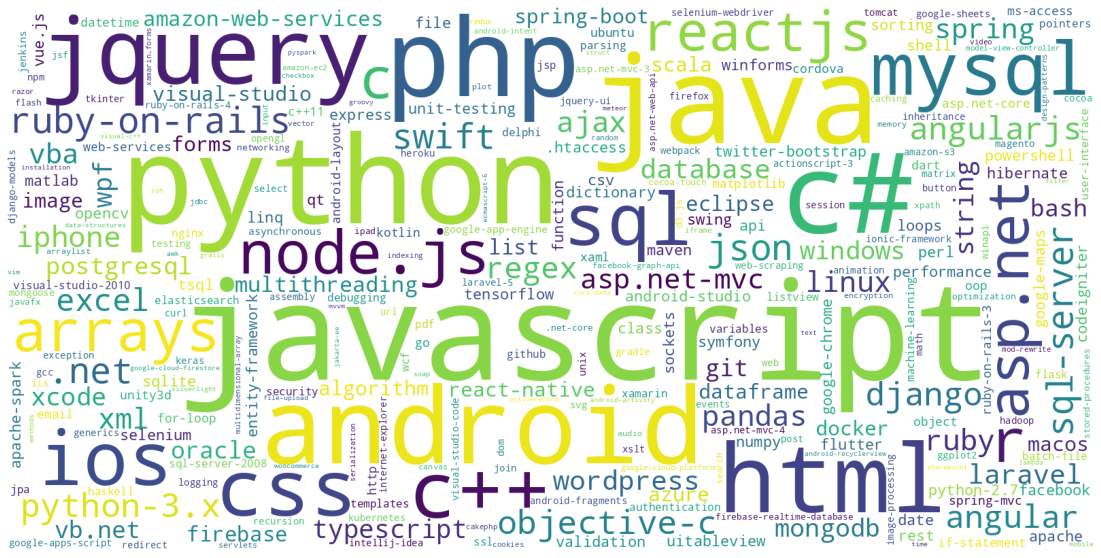

In [7]:
# This cell will illustrate the word cloud
# For this purpose, a dictionary of tag frequecies should be made out of the dataframe
tags_dict = {}
for k, v in tags_df.values:
    tags_dict[k] = v

# setting configs to illustrate the word cloud
cloud = wordcloud.WordCloud(background_color='white',
                            max_font_size=200,
                            width=1600,
                            height=800,
                            max_words=300,
                            relative_scaling=.5)
# genereate the word cloud from the dictionary of tag frequencies
cloud.generate_from_frequencies(frequencies=tags_dict)
plt.figure(figsize=(20,10))
plt.axis("off")
plt.imshow(cloud)

-----------

### 2. What are the popular Python-related tags?

To find the python-relavant tags, we will retrive all the tags in the `posts_questions` table that include python.We will illustrate the word cloud directly from the `tags` column.

In [8]:
# pick the tags column from the table of `posts_questions` with the condition that the string of tag includes the term `python`
python_related_tags_query = """
    SELECT
        tags
    FROM
        `bigquery-public-data.stackoverflow.posts_questions`
    WHERE
        tags like '%python%';
"""

In [9]:
# Let's examine the size of the query
dry_run_config = bigquery.QueryJobConfig(dry_run=True)
dry_run_query_job = client.query(python_related_tags_query, job_config=dry_run_config)
print("This query will process {} bytes.".format(dry_run_query_job.total_bytes_processed/1000000))

This query will process 592.996962 bytes.


In [10]:
python_related_tags_df = client.query(python_related_tags_query).to_dataframe()
python_related_tags_df.head()

/opt/conda/lib/python3.7/site-packages/google/cloud/bigquery/client.py:440: UserWarning: Cannot create BigQuery Storage client, the dependency google-cloud-bigquery-storage is not installed.
  "Cannot create BigQuery Storage client, the dependency "


,tags
0,python|python-3.x|flask|sqlalchemy|pytest
1,python|python-requests|suds|zeep
2,python|flask|fastapi|streamlit
3,python|html|django|django-templates|wagtail
4,python|opencv


In [11]:
# The strings in the tags column will all include the term `python`.
# However, when illustrating the word cloud, we do not want the python to occupy the space.
# So, we are going to remove any substring including python.
def remove_python_words(x):
    tags = []
    for i in x.split('|'):  # Recall that the tags in the string of tags were separated with '|'
        if 'python' in i:  # ignore all tags in the string including python
            continue
        tags.append(i)
    return ' '.join(tags)

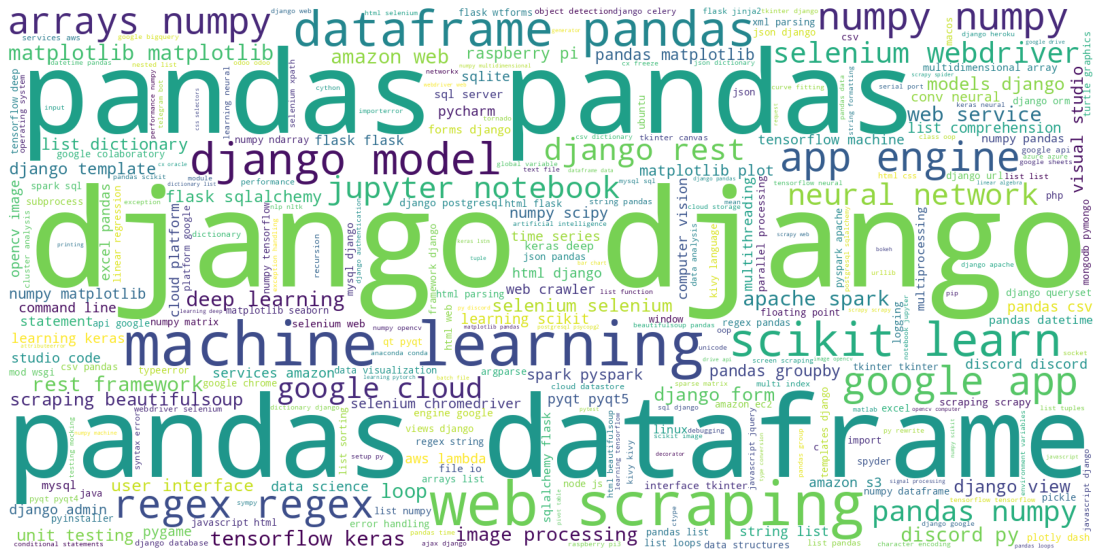

In [12]:
tags = ' '.join(python_related_tags_df.tags.apply(remove_python_words)).lower()
cloud = wordcloud.WordCloud(background_color='white',
                            max_font_size=200,
                            width=1600,
                            height=800,
                            max_words=300,
                            relative_scaling=.5).generate(tags)  # As you see, we generate the word cloud from superstring of tags
plt.figure(figsize=(20,10))
plt.axis('off')
plt.imshow(cloud)

----------------

### 3. How many new users have joined the community each year?

Let's create a bar chart of number of users per year to illustrate an answer to this question. We are going to need the year feature from users' `creation_date` and count the rows corresponding to each year. For this purpose, we should group users by the year they joined stackoverflow community. To retrieve an ordered table, we order the rows by year.

In [13]:
# EXTRACT is used to extract a sub-feature (here `year`) from a feature (here the `creation_date` which is a `DATETIME feature)
# In SQL, * is interpreted as all the rows
new_users_query = """
    SELECT
        EXTRACT(YEAR FROM creation_date) AS year,
        COUNT(*) AS n_new_users
    FROM
        `bigquery-public-data.stackoverflow.users`
    GROUP BY
        year
    ORDER BY
        year
"""

In [14]:
dry_run_config = bigquery.QueryJobConfig(dry_run=True)
dry_run_query_job = client.query(new_users_query, job_config=dry_run_config)
print("This query will process {} bytes.".format(dry_run_query_job.total_bytes_processed/1000000))

This query will process 124.31156 bytes.


In [15]:
new_users_df = client.query(new_users_query).to_dataframe()
new_users_df.head()

/opt/conda/lib/python3.7/site-packages/google/cloud/bigquery/client.py:440: UserWarning: Cannot create BigQuery Storage client, the dependency google-cloud-bigquery-storage is not installed.
  "Cannot create BigQuery Storage client, the dependency "


,year,n_new_users
0,2008,21646
1,2009,78007
2,2010,199205
3,2011,358720
4,2012,678857


<AxesSubplot:xlabel='year', ylabel='n_new_users'>

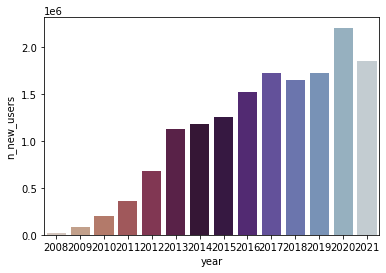

In [16]:
# Here, we use seaborn to illustrate a bar plot.
sns.barplot(data=new_users_df,
            x='year',
            y='n_new_users',
            palette='twilight_r')

-----------------

### 4. What is the yearly trend of adding posts on the website?

The query will be much like the previous one. However, we are going to use a line plot to show the trend. We will also add markers to indicate the precise number of posts in each year. We will also provide quick analysis profiles to show how effective they can be to give us an insight over the data.

In [17]:
post_counts_query = """
    SELECT
        EXTRACT(YEAR FROM creation_date) AS year,
        SUM(id) AS n_posts
    FROM
        `bigquery-public-data.stackoverflow.posts_questions`
    GROUP BY
        year
    ORDER BY
        year;
"""

In [18]:
dry_run_config = bigquery.QueryJobConfig(dry_run=True)
dry_run_query_job = client.query(post_counts_query, job_config=dry_run_config)
print("This query will process {} mega bytes.".format(dry_run_query_job.total_bytes_processed/1000000))

This query will process 346.268832 mega bytes.


In [19]:
post_counts_df = client.query(post_counts_query).to_dataframe()
post_counts_df.head()

/opt/conda/lib/python3.7/site-packages/google/cloud/bigquery/client.py:440: UserWarning: Cannot create BigQuery Storage client, the dependency google-cloud-bigquery-storage is not installed.
  "Cannot create BigQuery Storage client, the dependency "


,year,n_posts
0,2008,12720530072
1,2009,422324480224
2,2010,2287394031477
3,2011,7921810238173
4,2012,18615264849210


In [20]:
post_counts_df.describe()  # `describe` will provide statistical descriptions of the dataframe

,year,n_posts
count,14.0000,1.400000e+01
mean,2014.5000,5.554037e+13
std,4.1833,4.410368e+13
min,2008.0000,1.272053e+10
25%,2011.2500,1.059517e+13
50%,2014.5000,6.033825e+13
75%,2017.7500,9.394503e+13
max,2021.0000,1.245512e+14


In [21]:
pandas_profiling.ProfileReport(post_counts_df)

Summarize dataset:   0%|          | 0/15 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

In [22]:
# Although seaborn provides a lineplot for the purpose, the line plot provided by plotly is easier to work with
fig = px.line(post_counts_df,
        x='year',
        y='n_posts',
        markers=True)
fig.show()

---------------

### 5. What portion of questions asked in each year have been answered so far?

This question will give us an insight of whether there is a correlation between the age of the question and it being answered. We will use bar plots to answer the question.

In [23]:
# to find the percentage of answered questions in each year, we have to count the questions with `answer_count` of
# greater than zero and divide the result by the total number of questions in that year. We will round the result
# for 2 precision points.
answered_qs_query = """
    SELECT
        EXTRACT(YEAR from creation_date) AS year,
        COUNT(*) AS n_questions,
        ROUND(100 * SUM(IF(answer_count > 0, 1, 0)) / COUNT(*), 2) AS percent_answer
    FROM 
        `bigquery-public-data.stackoverflow.posts_questions`
    GROUP BY 
        year
    ORDER BY 
        year;
"""

In [24]:
dry_run_config = bigquery.QueryJobConfig(dry_run=True)
dry_run_query_job = client.query(answered_qs_query, job_config=dry_run_config)
print("This query will process {} mega bytes.".format(dry_run_query_job.total_bytes_processed/1000000))

This query will process 346.268832 mega bytes.


In [25]:
ans_percent_df = client.query(answered_qs_query).to_dataframe()
ans_percent_df.head()

/opt/conda/lib/python3.7/site-packages/google/cloud/bigquery/client.py:440: UserWarning:

Cannot create BigQuery Storage client, the dependency google-cloud-bigquery-storage is not installed.



,year,n_questions,percent_answer
0,2008,57801,99.87
1,2009,342158,99.64
2,2010,691587,99.03
3,2011,1191465,97.53
4,2012,1631497,95.06


<AxesSubplot:xlabel='year', ylabel='percent_answer'>

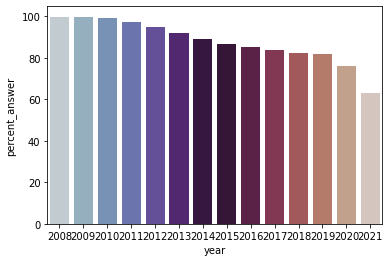

In [26]:
# Here, we will see what is the percentage of answers each year
sns.barplot(data=ans_percent_df, 
             x="year", 
             y="percent_answer", 
             palette="twilight",
            )

In [27]:
# To have a comparative result, let's retrieve the number of answers
ans_percent_df["n_answered"] = (ans_percent_df["percent_answer"] * ans_percent_df["n_questions"])//100
ans_percent_df.head()

,year,n_questions,percent_answer,n_answered
0,2008,57801,99.87,57725.0
1,2009,342158,99.64,340926.0
2,2010,691587,99.03,684878.0
3,2011,1191465,97.53,1162035.0
4,2012,1631497,95.06,1550901.0


In [28]:
# We can now plot the bars alongside to provide a better insight over the portion of the questions with answer
# This time, we use plotly for ease of use
fig = px.bar(ans_percent_df,
             x="year",
             y=["n_questions", "n_answered"],
             barmode="group",
             color_discrete_sequence=px.colors.qualitative.Pastel1)
fig.update_layout()
fig.show()

-----------------

### 6. What is the trend of big data technologies over the years?

Let's take a look at some big data technologies. The queries are like the previous ones and do not have additive complexities.

In [29]:
bigdata_query = """
    SELECT
        EXTRACT(YEAR FROM creation_date) AS year,
        SUM(id) as n_posts
    FROM
        `bigquery-public-data.stackoverflow.posts_questions`
    WHERE
        tags like '%hadoop%' or tags like '%spark%' or tags like '%hbase%' or tags like '%kafka%' or tags like '%hive%'
        or tags like '%cassandra%'
    GROUP BY
        year
    ORDER BY
        year;
"""

In [30]:
bigdata_df = client.query(bigdata_query).to_dataframe()
bigdata_df.head()

/opt/conda/lib/python3.7/site-packages/google/cloud/bigquery/client.py:440: UserWarning:

Cannot create BigQuery Storage client, the dependency google-cloud-bigquery-storage is not installed.



,year,n_posts
0,2008,8985987
1,2009,336758628
2,2010,3062406548
3,2011,15484817272
4,2012,55774385176


In [31]:
bigdata_df.describe()

,year,n_posts
count,14.0000,1.400000e+01
mean,2014.5000,6.114022e+11
std,4.1833,5.992825e+11
min,2008.0000,8.985987e+06
25%,2011.2500,2.555721e+10
50%,2014.5000,4.489541e+11
75%,2017.7500,1.169787e+12
max,2021.0000,1.541255e+12


In [32]:
# let's add the column of `n_posts` from `post_counts_df` to a copy of `bigdata_df`
bigdata_count_vs_all_df = bigdata_df.copy()
bigdata_count_vs_all_df['total'] = post_counts_df['n_posts']
bigdata_count_vs_all_df

,year,n_posts,total
0,2008,8985987,12720530072
1,2009,336758628,422324480224
2,2010,3062406548,2287394031477
3,2011,15484817272,7921810238173
4,2012,55774385176,18615264849210
5,2013,145064988854,35690017419736
6,2014,286790519196,52126968250432
7,2015,611117617126,68549522258557
8,2016,1013108722285,83711714382627
9,2017,1210127147387,94799465285575


In [33]:
# Now we can have a comparison over the trend of total posts each year and the contribution of big data technologies
fig = px.bar(bigdata_count_vs_all_df,
             x='year',
             y=['n_posts', 'total'],
             color_discrete_sequence=px.colors.qualitative.Pastel1)
fig.show()

In [34]:
# As shown above, a few portion of yearly contributions includes big data.
# Let's scale the two columns to see how similar are the yearly trends of total contributions and big data posts
scaler = MinMaxScaler()  # This class is to perform a min-max scaling in range [0, 1]

# Firstly, we will create a 2d array from the two columns
arr = np.array(bigdata_count_vs_all_df.n_posts)
arr = np.stack((arr,np.array(bigdata_count_vs_all_df.total)),axis=1)  # stack will simply put the two columns in the form of a 2d array of shape (n,2)

scaled = scaler.fit_transform(arr)  # Here, the scaling is applied on the constructed 2d array

# Now we add two new columns containing these scaled values
bigdata_count_vs_all_df["scaled_n_posts"] = scaled[:,0]
bigdata_count_vs_all_df["scaled_total"] = scaled[:,1]
bigdata_count_vs_all_df.head()

,year,n_posts,total,scaled_n_posts,scaled_total
0,2008,8985987,12720530072,0.000000,0.000000
1,2009,336758628,422324480224,0.000213,0.003289
2,2010,3062406548,2287394031477,0.001981,0.018265
3,2011,15484817272,7921810238173,0.010041,0.063507
4,2012,55774385176,18615264849210,0.036182,0.149372


In [35]:
# Let's see the yearly trend of big data posts first
fig = px.line(bigdata_df,
              x='year',
              y='n_posts',
              markers=True)
fig.show()

In [36]:
# And now, we can plot the trends alongside
fig = px.line(bigdata_count_vs_all_df,
              x='year',
              y=['scaled_n_posts', 'scaled_total'],
              markers=True)
fig.show()

Now we will have a deeper look on each of the big data technologies, themselves, and compare them.

In [37]:
hadoop_query = """
    SELECT
        EXTRACT(YEAR FROM creation_date) AS year,
        SUM(id) as n_posts
    FROM
        `bigquery-public-data.stackoverflow.posts_questions`
    WHERE
        tags like '%hadoop%'
    GROUP BY
        year
    ORDER BY
        year;
"""

spark_query = """
    SELECT
        EXTRACT(YEAR FROM creation_date) AS year,
        SUM(id) as n_posts
    FROM
        `bigquery-public-data.stackoverflow.posts_questions`
    WHERE
        tags like '%spark%'
    GROUP BY
        year
    ORDER BY
        year;
"""

hbase_query = """
    SELECT
        EXTRACT(YEAR FROM creation_date) AS year,
        SUM(id) as n_posts
    FROM
        `bigquery-public-data.stackoverflow.posts_questions`
    WHERE
        tags like '%hbase%'
    GROUP BY
        year
    ORDER BY
        year;
"""

hive_query = """
    SELECT
        EXTRACT(YEAR FROM creation_date) AS year,
        SUM(id) as n_posts
    FROM
        `bigquery-public-data.stackoverflow.posts_questions`
    WHERE
        tags like '%hive%'
    GROUP BY
        year
    ORDER BY
        year;
"""

cassandra_query = """
    SELECT
        EXTRACT(YEAR FROM creation_date) AS year,
        SUM(id) as n_posts
    FROM
        `bigquery-public-data.stackoverflow.posts_questions`
    WHERE
        tags like '%cassandra%'
    GROUP BY
        year
    ORDER BY
        year;
"""

kafka_query = """
    SELECT
        EXTRACT(YEAR FROM creation_date) AS year,
        SUM(id) as n_posts
    FROM
        `bigquery-public-data.stackoverflow.posts_questions`
    WHERE
        tags like '%kafka%'
    GROUP BY
        year
    ORDER BY
        year;
"""

In [38]:
hadoop_df = client.query(hadoop_query).to_dataframe()
spark_df = client.query(spark_query).to_dataframe()
hive_df = client.query(hive_query).to_dataframe()
hbase_df = client.query(hbase_query).to_dataframe()
cassandra_df = client.query(cassandra_query).to_dataframe()
kafka_df = client.query(kafka_query).to_dataframe()

/opt/conda/lib/python3.7/site-packages/google/cloud/bigquery/client.py:440: UserWarning:

Cannot create BigQuery Storage client, the dependency google-cloud-bigquery-storage is not installed.



In [39]:
# So far, we have distinct dataframes for each technology. Here, we try to make a single dataframe containing
# the data of all the desired technologies by adding a `type` column.
hadoop_df["type"] = "hadoop"
spark_df["type"] = "spark"
hive_df["type"] = "hive"
hbase_df["type"] = "hbase"
kafka_df["type"] = "kafka"
cassandra_df["type"] = "cassandra"
bigdata_tech_df = pd.concat([hadoop_df,spark_df,hive_df,hbase_df,cassandra_df,kafka_df])
bigdata_tech_df.head()

,year,n_posts,type
0,2008,2398042,hadoop
1,2009,98741644,hadoop
2,2010,1065776035,hadoop
3,2011,7287989249,hadoop
4,2012,31406444304,hadoop


In [40]:
# Now we can see the trend of each technology and compare it with the trend of others
fig = px.line(bigdata_tech_df,
              x='year',
              y='n_posts',
              color='type',
              markers=True,
             color_discrete_sequence=px.colors.qualitative.Dark24)
fig.show()

-------------------

### 7. Compare the trend of Python vs. R.

Python or R, that's the issue. We will find the posts related to each of these subjects and compare their trends.

**NOTE:** Although R is more specifically used in statistics and data-related domains while python is a more general-purpose language, we will not make this fact into consideration.

In [41]:
# HAVING is another way of conditioning a query. It differs from WHERE in the sense that WHERE iterates individual
# rows, while HAVING puts a condition over aggregations and is used after grouping the data.
python_query = """
    SELECT
        REGEXP_EXTRACT(tags, "python") AS tag,
        EXTRACT(YEAR FROM creation_date) AS year,
        COUNT(*) AS n_posts
    FROM
        `bigquery-public-data.stackoverflow.posts_questions`
    GROUP BY
        tag, year
    HAVING
        tag IS NOT NULL
    ORDER BY
        year;
"""

r_query = """
    SELECT
        REGEXP_EXTRACT(tags, "^r$") AS tag,
        EXTRACT(YEAR FROM creation_date) AS year,
        COUNT(*) AS n_posts
    FROM
        `bigquery-public-data.stackoverflow.posts_questions`
    GROUP BY
        tag, year
    HAVING
        tag IS NOT NULL
    ORDER BY
        year;
"""

In [42]:
dry_run_config = bigquery.QueryJobConfig(dry_run=True)

dry_run_query_job = client.query(python_query, job_config=dry_run_config)

print("This query will process {} bytes.".format(dry_run_query_job.total_bytes_processed/1000000))

dry_run_config = bigquery.QueryJobConfig(dry_run=True)

dry_run_query_job = client.query(r_query, job_config=dry_run_config)

print("This query will process {} bytes.".format(dry_run_query_job.total_bytes_processed/1000000))

This query will process 766.131378 bytes.
This query will process 766.131378 bytes.


In [43]:
python_df = client.query(python_query).to_dataframe()
r_df = client.query(r_query).to_dataframe()

/opt/conda/lib/python3.7/site-packages/google/cloud/bigquery/client.py:440: UserWarning:

Cannot create BigQuery Storage client, the dependency google-cloud-bigquery-storage is not installed.



In [44]:
python_df.head()

,tag,year,n_posts
0,python,2008,2102
1,python,2009,13206
2,python,2010,27533
3,python,2011,43023
4,python,2012,66577


In [45]:
r_df.head()

,tag,year,n_posts
0,r,2008,1
1,r,2009,48
2,r,2010,402
3,r,2011,1173
4,r,2012,2524


In [46]:
python_vs_r_df = python_df.append(r_df)
python_vs_r_df

,tag,year,n_posts
0,python,2008,2102
1,python,2009,13206
2,python,2010,27533
3,python,2011,43023
4,python,2012,66577
5,python,2013,101751
6,python,2014,123479
7,python,2015,147156
8,python,2016,173210
9,python,2017,213113


In [47]:
fig = px.line(python_vs_r_df,
             x='year',
             y='n_posts',
             color='tag',
             markers=True)
fig.show()

---------------------

### 8. Compare users with respect to their contributions (question contributer, answer contributer, contributer to both, or only an observer).

To do this task, we need to join the tables of questions and answers based on the user ids. To find the visitors, we will also need the table of all the users.

In [48]:
# LEFT JOIN will include all the records from the first table, along with the matching records from the second table.
# Joining two tables needs an identifier column which is specified using the ON keyword.
# Also note for the ease of reference, we have made aliases for the tables.
# Question contributer is an individual who has a record in the questions table but not records in the answers table.
q_contributer_query = """
    SELECT
        COUNT(DISTINCT Q.owner_user_id)
    FROM
        `bigquery-public-data.stackoverflow.posts_questions` Q
    LEFT JOIN
        `bigquery-public-data.stackoverflow.posts_answers` A
    ON
        Q.owner_user_id = A.owner_user_id
    WHERE
        A.owner_user_id IS NULL;
"""

# The reverse of above is an answer contributer.
a_contributer_query = """
    SELECT
        COUNT(DISTINCT A.owner_user_id)
    FROM
        `bigquery-public-data.stackoverflow.posts_answers` A
    LEFT JOIN
        `bigquery-public-data.stackoverflow.posts_questions` Q
    ON
        Q.owner_user_id = A.owner_user_id
    WHERE
        Q.owner_user_id IS NULL;
"""

# INNER JOIN will select the matching records in both tables.
qa_contributer_query = """
    SELECT
        COUNT(DISTINCT Q.owner_user_id)
    FROM
        `bigquery-public-data.stackoverflow.posts_questions` Q
    INNER JOIN
        `bigquery-public-data.stackoverflow.posts_answers` A
    ON
        Q.owner_user_id = A.owner_user_id
"""

# Among all the users, find the ones that have no record in any of the questions and answers tables.
observer_query = """
    SELECT
        COUNT(DISTINCT id)
    FROM
        `bigquery-public-data.stackoverflow.users` all_users
    LEFT JOIN (
        SELECT DISTINCT owner_user_id
        FROM `bigquery-public-data.stackoverflow.posts_answers`
        UNION ALL
        SELECT DISTINCT owner_user_id
        FROM `bigquery-public-data.stackoverflow.posts_questions`
    ) active_users
    ON
        all_users.id = active_users.owner_user_id
    WHERE
        active_users.owner_user_id IS NULL;
"""

In [49]:
q_contributer = client.query(q_contributer_query).to_dataframe()
a_contributer = client.query(a_contributer_query).to_dataframe()
qa_contributer = client.query(qa_contributer_query).to_dataframe()
observer = client.query(observer_query).to_dataframe()

/opt/conda/lib/python3.7/site-packages/google/cloud/bigquery/client.py:440: UserWarning:

Cannot create BigQuery Storage client, the dependency google-cloud-bigquery-storage is not installed.



In [50]:
contribution_type_df = pd.DataFrame(columns=["user_type", "n_users"],
                                    data=[["q_contributer", q_contributer.values[0][0]], 
                                          ["a_contributer", a_contributer.values[0][0]],
                                          ["qa_contributer", qa_contributer.values[0][0]], 
                                          ["observer", observer.values[0][0]]])
contribution_type_df

,user_type,n_users
0,q_contributer,2731009
1,a_contributer,1099171
2,qa_contributer,1574021
3,observer,10134747


In [51]:
# This time, a pie chart might be a better visualization tool, since there are multiple classes of discrete values which
# if added up, construct the whole population.
fig = px.pie(contribution_type_df, values="n_users", names="user_type",
             color_discrete_sequence=px.colors.qualitative.Pastel)
fig.show()

--------------------

### 9. Upon sorting users by their reputation, what is the number of their answered and unanswered questions?

This one requires a lot of work! We need to make a sorting of the users based on their reputation, as well as counting the number of their questions and the answered and unanswered ones.

In [52]:
# Starting with the inner queries first, we will do as we did before to find the questions in each category.
# Now, we make a categorical ordering of the users with respect to their reputation given the result of the
# previous calculation. Finally, we can make the countings and build a new table from the previously 
# constructed table. Note that we have added alphabets to the beginning of the reputation categories.
# This to ensure that the ordering will be performed correctly. You can run the query once without those
# additional alphabets and see how the output changes.
rep_query = """
    SELECT
        rep_range,
        COUNT(*) AS n_users,
        SUM(asked) AS n_asked_question,
        SUM(unanswered) AS n_unanswered_question,
        SUM(answered) AS n_contributed_answer
    FROM(
        SELECT 
            CASE
                WHEN reputation BETWEEN 1 AND 100 THEN 'a1-100'
                WHEN reputation BETWEEN 101 AND 1000 THEN 'b101-1000'
                WHEN reputation BETWEEN 1001 AND 10000 THEN 'c1001-10000'
                WHEN reputation BETWEEN 10001 AND 100000 THEN 'd10001-100000'
                WHEN reputation > 100000 THEN 'e> 100000'
            END AS rep_range,
            asked,
            answered,
            unanswered
        FROM(    
            SELECT id AS user_id, reputation, asked, answered, unanswered
            FROM `bigquery-public-data.stackoverflow.users` users
            LEFT JOIN(
                SELECT owner_user_id AS user_id, COUNT(*) AS asked
                FROM `bigquery-public-data.stackoverflow.posts_questions`
                GROUP BY user_id
            ) Q 
            ON users.id = Q.user_id
            LEFT JOIN(
                SELECT owner_user_id AS user_id, COUNT(*) AS answered
                FROM `bigquery-public-data.stackoverflow.posts_answers`
                GROUP BY user_id
            ) A 
            ON users.id = A.user_id
            LEFT JOIN(
                SELECT owner_user_id AS user_id, COUNT(*) AS unanswered 
                FROM (
                    SELECT owner_user_id
                    FROM `bigquery-public-data.stackoverflow.posts_questions`
                    WHERE answer_count=0
                )
                GROUP BY user_id
            ) UA 
            ON users.id = UA.user_id
        )
    )
    GROUP BY
        rep_range
    ORDER BY
        rep_range
"""

In [53]:
rep_df = client.query(rep_query).to_dataframe()
rep_df.head()

/opt/conda/lib/python3.7/site-packages/google/cloud/bigquery/client.py:440: UserWarning:

Cannot create BigQuery Storage client, the dependency google-cloud-bigquery-storage is not installed.



,rep_range,n_users,n_asked_question,n_unanswered_question,n_contributed_answer
0,a1-100,14437129,7447057,1473566,3221372
1,b101-1000,867781,6506494,905722,6165460
2,c1001-10000,210168,5535124,578203,10631682
3,d10001-100000,22829,1655770,107938,8439186
4,e> 100000,1038,90681,3326,3419158


In [54]:
# Let's remove the first additional character from the `rep_range` column
# `apply` will apply a function row-wise on the dataframe
# `lambda` is used to write an inline function. `lambda x: x[1:]` is equivalent to the function f below:
# def f(x):
#     return x[1:]
rep_df['rep_range'] = rep_df.rep_range.apply(lambda x: x[1:])
rep_df.head()

,rep_range,n_users,n_asked_question,n_unanswered_question,n_contributed_answer
0,1-100,14437129,7447057,1473566,3221372
1,101-1000,867781,6506494,905722,6165460
2,1001-10000,210168,5535124,578203,10631682
3,10001-100000,22829,1655770,107938,8439186
4,> 100000,1038,90681,3326,3419158


In [55]:
# Let's have a glance on how users are distributed based on their reputation
fig = px.pie(rep_df, values="n_users", names="rep_range",
             color_discrete_sequence=px.colors.qualitative.Pastel)
fig.show()

In [56]:
# Now we will try to make a dataframe containing the information we need to answer the above question.
rep_percent_df = rep_df.copy()
rep_percent_df.rename(columns={"n_users": "users_percent", 
                               "n_asked_question": "asked_question_percent",
                               "n_unanswered_question": "unanswered_question_percent",
                               "n_contributed_answer": "contributed_answer_percent"}, inplace=True)

rep_percent_df["users_percent"] = round(rep_percent_df.users_percent * 100 / rep_percent_df.users_percent.sum(), 2)

rep_percent_df["asked_question_percent"] = round(
    rep_percent_df.asked_question_percent * 100 / rep_percent_df.asked_question_percent.sum(), 2
)

rep_percent_df["unanswered_question_percent"] = round(
    rep_percent_df.unanswered_question_percent * 100 / rep_percent_df.unanswered_question_percent.sum(), 2
)

rep_percent_df["contributed_answer_percent"] = round(
    rep_percent_df.contributed_answer_percent * 100 / rep_percent_df.contributed_answer_percent.sum(), 2
)

rep_percent_df["answer_rate"] = round(100 *
    (rep_df.n_asked_question - rep_df.n_unanswered_question) / rep_df.n_asked_question, 2
)

rep_percent_df

,rep_range,users_percent,asked_question_percent,unanswered_question_percent,contributed_answer_percent,answer_rate
0,1-100,92.91,35.07,48.02,10.11,80.21
1,101-1000,5.58,30.64,29.51,19.34,86.08
2,1001-10000,1.35,26.07,18.84,33.35,89.55
3,10001-100000,0.15,7.80,3.52,26.47,93.48
4,> 100000,0.01,0.43,0.11,10.73,96.33


--------------------------

### 10. Retrieve 100K posts from the available posts on the site.

This final task is quite easy. The only complication might be how to select 100K posts/rows which can easily be handled by a `LIMIT` keyword.

In [57]:
test_query = """
    SELECT id, title, body, accepted_answer_id, answer_count, comment_count, favorite_count,
            view_count, tags, creation_date, last_activity_date, score
    FROM
        `bigquery-public-data.stackoverflow.stackoverflow_posts`
    LIMIT 10000
"""

test_df = client.query(test_query).to_dataframe()
test_df.head()

/opt/conda/lib/python3.7/site-packages/google/cloud/bigquery/client.py:440: UserWarning:

Cannot create BigQuery Storage client, the dependency google-cloud-bigquery-storage is not installed.



,id,title,body,accepted_answer_id,answer_count,comment_count,favorite_count,view_count,tags,creation_date,last_activity_date,score
0,525063,Android Respond To URL in Intent,<p>I want my intent to be launched when the us...,525086.0,1.0,2,65.0,91060.0,android|url|android-intent|intentfilter|launch,2009-02-08 02:55:56.867000+00:00,2016-04-10 03:28:09.653000+00:00,132
1,14128723,Eclipse -- Progress windows don't show up any ...,<p>I used to see both Building and Cleaning ac...,14128762.0,1.0,0,4.0,4272.0,java|eclipse,2013-01-02 20:31:53.523000+00:00,2013-01-02 20:34:55.003000+00:00,13
2,20728,What's the best way to create ClickOnce deploy...,<p>Our team develops distributed winform apps....,20806.0,2.0,0,5.0,2534.0,winforms|deployment|clickonce,2008-08-21 18:35:04.410000+00:00,2015-11-30 02:03:49.403000+00:00,13
3,6531409,iOS: how to get image dimensions without openi...,<p>In an iOS app I need to provide image filte...,8731972.0,2.0,2,4.0,2837.0,ios4|uikit,2011-06-30 07:33:38.647000+00:00,2014-04-22 17:16:44.230000+00:00,7
4,593205,action delegate with zero parameters,<p>I see this line in many online examples of ...,593223.0,2.0,3,6.0,12377.0,c#|delegates|action,2009-02-27 01:30:27.723000+00:00,2012-01-12 01:44:40.020000+00:00,21


For a final touch, let's see how many of the retrieved posts do not have an accepted answer and how many of them are still not answered.

In [58]:
len(test_df[test_df.accepted_answer_id.isna()])

2371

In [59]:
len(test_df[test_df.answer_count == 0])

44

----------------------------------------
----------------------------------------

# References

[Google BigQuery Documentation](https://cloud.google.com/bigquery/docs)

[Python Client for BigQuery](https://googleapis.dev/python/bigquery/latest/index.html)

[How to Query Stack Overflow Data Notebook](https://www.kaggle.com/paultimothymooney/how-to-query-the-stack-overflow-data)

[Stack Overflow Big Data Analysis Notebook](https://www.kaggle.com/tonyliu1204/stack-overflow-big-data-analysis)

[Stack Overflow dive deep using BigQuery Notebook](https://www.kaggle.com/arvinthsss/stack-overflow-dive-deep-using-bigquery)

[Stack Overflow Data Notebook](https://www.kaggle.com/fluffyhamster/stack-overflow-data)

[Trends in technology Notebook](https://www.kaggle.com/harikabalusa/trends-in-technology)

[Plotly Python Open Source Graphing Library](https://plotly.com/python/)

[Seaborn Documentation and Tutorials](https://seaborn.pydata.org/)

[Pandas Getting Started Tutorial](https://pandas.pydata.org/docs/getting_started/intro_tutorials/index.html)

[SQL Tutorial](https://www.w3schools.com/sql/)

[BigQuery ML Documentation](https://cloud.google.com/bigquery-ml/docs/introduction)

[BigQuery Machine Learning Tutorial Notebook](https://www.kaggle.com/rtatman/bigquery-machine-learning-tutorial)